# DICOVSEL with exact criterion of DIPALS

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtply
import pandas as pd
import scipy as sp
import scipy.io as sp_io
from scipy.spatial.distance import cdist
from pycaltransfer import caltransfer

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression



from class_sample_selection import sample_selection as samplesel
from dicovsel_functions import covsel, dicovsel, convex_relaxation
from dipls_functions import dipals as dipls
from dipls_functions import cross_val_predict_dipls

In [2]:
def performance_measures(Y,  Yp):
    
    rmsep_s = np.sqrt(mean_squared_error(Y, Yp))
    bias_s = np.mean(Y - Yp)
    r2p_s = np.power(np.corrcoef(Y.T, Yp.T)[0,1],2)
    sep_s = np.sqrt(np.mean(np.power(Y - Yp - bias_s,2)))
    
    
    return rmsep_s, bias_s, r2p_s, sep_s


## Rice data

data sets:  dict_keys(['__header__', '__version__', '__globals__', 'b1', 'b2'])
elements in b2:  [('x', 'O'), ('y', 'O'), ('w', 'O')]
total source samples:  200


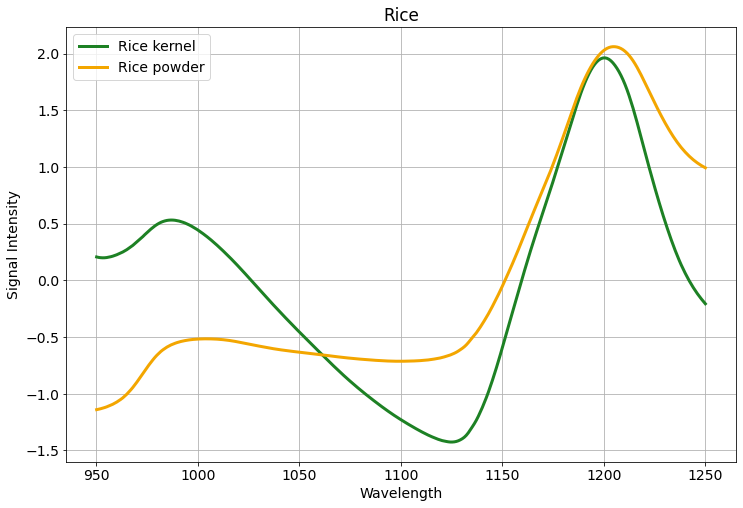

In [4]:
source_name = "Rice kernel"
target_name = "Rice powder"

rice_kernel_to_powder = sp_io.loadmat("rice_kernel_to_powder.mat", struct_as_record = True)
print("data sets: ",rice_kernel_to_powder.keys())
print("elements in b2: ",rice_kernel_to_powder["b2"][0][0].dtype)

Xs_0 = rice_kernel_to_powder["b1"][0][0][0]
Ys_0 = rice_kernel_to_powder["b1"][0][0][1]
print("total source samples: ", Xs_0.shape[0])

wv_range = rice_kernel_to_powder["b1"][0][0][2].flatten()

Xt_all = rice_kernel_to_powder["b2"][0][0][0]
Yt_all = rice_kernel_to_powder["b2"][0][0][1]



plt.rcParams.update({'font.size': 14})
plt.subplots(figsize = (12, 8))
plt.plot(wv_range, Xs_0.mean(axis=0), c = "#1d8124",  linewidth = 3, label = source_name)
plt.plot(wv_range, Xt_all.mean(axis=0), c = "#f3a600", linewidth = 3, label = target_name)
plt.legend(loc = 2)
plt.xlabel("Wavelength")
plt.ylabel("Signal Intensity")
plt.title("Rice")
plt.grid()
plt.savefig("./figures/rice_data.png")
plt.show()


# Set seed for reproducibility
# rng = np.random.RandomState(7620987)
rng = np.random.RandomState(52689)



# Divide set Xt


t_samples = rng.choice(Xt_all.shape[0], np.int32(Xt_all.shape[0]*0.3), replace = False)
t_test_samples = np.asarray([ii for ii in range(Xt_all.shape[0]) if ii not in t_samples])

Xt = Xt_all[t_samples,:]
Yt = Yt_all[t_samples,:]

Xt_test = Xt_all[t_test_samples,:]
Yt_test = Yt_all[t_test_samples,:]




## Recenter Xs with mean of Xt. Then divide set Xs 
#### This is a bias correction that happens also in DIPALS. Here we select 10 KS samples for this purpose. Initially we correct the bias only on Xs, but if there's a bias problem for Y, Ys also would need to be corrected which in reality would require a fe

In [5]:
# samples to recenter

ncenter = 10
my_ss = samplesel(Xt, ncp = ncenter - 1)
my_ss.get_pca_scores()
ss_ks = my_ss.kennard_stone(Nout=ncenter, dim_reduction = True, distance_measure = "mahalanobis")
center_samples = ss_ks["sample_id"][:,0] == 1

Xcenter = Xt[center_samples,:]
Ycenter = Yt[center_samples]

Ys_all = Ys_0.copy()
Xs_all = Xs_0.copy() - Xs_0.mean(axis=0) + Xcenter.mean(axis=0)

# Divide set Xs

s_samples = rng.choice(Xs_all.shape[0], np.int32(Xs_all.shape[0]*0.7), replace = False)
s_test_samples = np.asarray([ii for ii in range(Xs_all.shape[0]) if ii not in s_samples])

Xs = Xs_all[s_samples,:]
Ys = Ys_all[s_samples,:]

Xs_test = Xs_all[s_test_samples,:]
Ys_test = Ys_all[s_test_samples,:]




# Descriptive

In [6]:
desc = {}

desc["wv_min"] = np.amin(wv_range)
desc["wv_max"] = np.amax(wv_range)
desc["source_n"] = Xs.shape[0]
desc["source_test_n"] = Xs_test.shape[0]
desc["target_n"] = Xt.shape[0]
desc["target_test_n"] = Xt_test.shape[0]


desc["source_mean"] = Ys.mean(axis=0) 
desc["source_test_mean"] = Ys_test.mean(axis=0)
desc["target_mean"] = Yt.mean(axis=0)
desc["target_test_mean"] = Yt_test.mean(axis=0)


desc["source_std"] = Ys.std(axis=0) 
desc["source_test_std"] = Ys_test.std(axis=0)
desc["target_std"] = Yt.std(axis=0)
desc["target_test_std"] = Yt_test.std(axis=0)


pd.DataFrame.from_dict(desc)


,wv_min,wv_max,source_n,source_test_n,target_n,target_test_n,source_mean,source_test_mean,target_mean,target_test_mean,source_std,source_test_std,target_std,target_test_std
0,950.1538,1250.042,140,60,60,140,9.072762,9.025978,9.197515,8.999246,1.46836,1.576564,1.483373,1.505707


# PLS total range

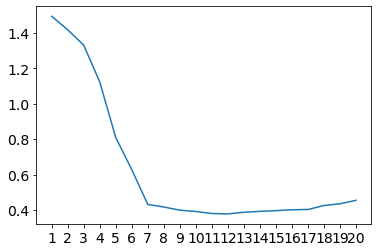

In [7]:
total_lv = 20
n_splits_cv = 10
xcal_pls = Xs.copy()
ycal_pls = Ys.copy()


rmsecv_original = np.zeros(total_lv)
r2cv_original = np.zeros(total_lv)

for lvi,lv in enumerate(range(1, total_lv+1)):    
    
    my_pls = PLSRegression(n_components = lv,scale=False)      
    ycal_cv = cross_val_predict(my_pls, xcal_pls, ycal_pls, cv = n_splits_cv)
    rmsecv_original[lvi] = np.sqrt(mean_squared_error(ycal_pls, ycal_cv))
    r2cv_original[lvi] = np.power(np.corrcoef(ycal_pls.T, ycal_cv.T)[0,1],2)
    
plt.plot(np.arange(1, total_lv+1),rmsecv_original)
plt.xticks(np.arange(1, total_lv+1))
plt.show()

In [8]:

chosen_lv = 7
my_pls = PLSRegression(n_components = chosen_lv,scale=False)
my_pls.fit(xcal_pls, ycal_pls)
x_mean = xcal_pls.mean(axis=0)
y_mean = ycal_pls.mean(axis=0)

# deliver model

B = my_pls.coef_
beta = y_mean - (x_mean.dot(B))


# crossval performance

ycal_cv = cross_val_predict(my_pls, xcal_pls, ycal_pls, cv = n_splits_cv)

# source and target

Ys_test_pred = Xs_test.dot(B) + beta

Yt_test_pred = Xt_test.dot(B) + beta


# Evaluate PLS


rmsecv_s, bias_cv_s, r2cv_s, sepcv_s = performance_measures(ycal_pls, ycal_cv)
rmsep_s, bias_p_s, r2p_s, sepp_s = performance_measures(Ys_test, Ys_test_pred)
rmsep_t, bias_p_t, r2p_t, sepp_t = performance_measures(Yt_test, Yt_test_pred)



model_performance = {}
model_performance["Property"] = "Rice"
model_performance["Model"] = "PLS full spectral range"
model_performance["LV"] = chosen_lv
model_performance["RMSECV"] = "{:.2f}".format(rmsecv_s)
model_performance["R2CV"] = "{:.2f}".format(r2cv_s)
model_performance["BiasCV"] = "{:.2f}".format(bias_cv_s)
model_performance["SEPCV"] = "{:.2f}".format(sepcv_s)

model_performance["RMSEP (source)"] = "{:.2f}".format(rmsep_s)
model_performance["R2P (source)"] = "{:.2f}".format(r2p_s)
model_performance["BiasP_s"] = "{:.2f}".format(bias_p_s)
model_performance["SEPP_s"] = "{:.2f}".format(sepp_s)


model_performance["RMSEP (target)"] = "{:.2f}".format(rmsep_t)
model_performance["R2P (target)"] = "{:.2f}".format(r2p_t)
model_performance["BiasP_t"] = "{:.2f}".format(bias_p_t)
model_performance["SEPP_t"] = "{:.2f}".format(sepp_t)


pd.DataFrame([model_performance])

# plt.scatter(Yt_test,Yt_test_pred)
# plt.show()

,Property,Model,LV,RMSECV,R2CV,BiasCV,SEPCV,RMSEP (source),R2P (source),BiasP_s,SEPP_s,RMSEP (target),R2P (target),BiasP_t,SEPP_t
0,Rice,PLS full spectral range,7,0.43,0.91,0.00,0.43,0.44,0.93,-0.04,0.44,0.64,0.84,0.16,0.62


# Covsel

In [9]:
covsel_output = covsel(Xs,Ys,nvar = Xs.shape[1]-1, scaleY = False, weights = None)
selected_covsel = covsel_output[0]


## CV Covsel

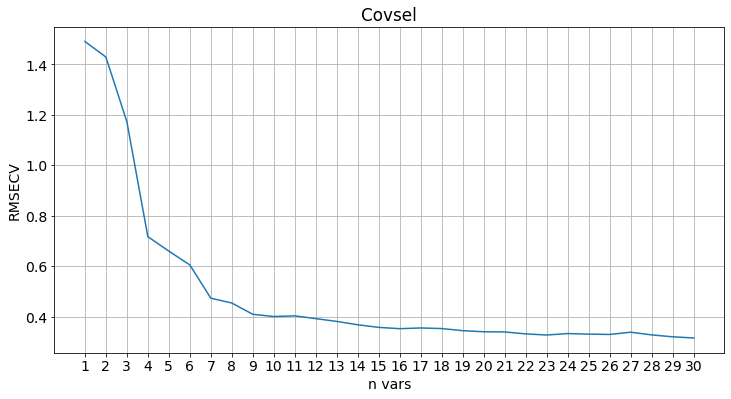

In [10]:
tvar = 30

mlr_covsel = LinearRegression()
mlr_scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}

mlr_covsel_rmsecv = np.zeros(tvar)

for nvars_i in range(1,tvar+1):
    
    mlr_covsel_cv = cross_validate(mlr_covsel, Xs[:, selected_covsel[0:nvars_i]],Ys, cv=10, scoring = mlr_scoring)
    mlr_covsel_rmsecv[nvars_i-1] = np.sqrt(-1*mlr_covsel_cv["test_mse"].mean())

    
    
plt.subplots(figsize = (12,6))
plt.plot(np.arange(1, tvar+1), mlr_covsel_rmsecv)
plt.xlabel("n vars")
plt.ylabel("RMSECV")
plt.xticks(np.arange(1, tvar+1))
plt.title("Covsel")
plt.grid()
plt.show()

### According to the previous result, between 9 and 13 variables would be selected. We select here 10 as a middle point.

## Selected Covsel

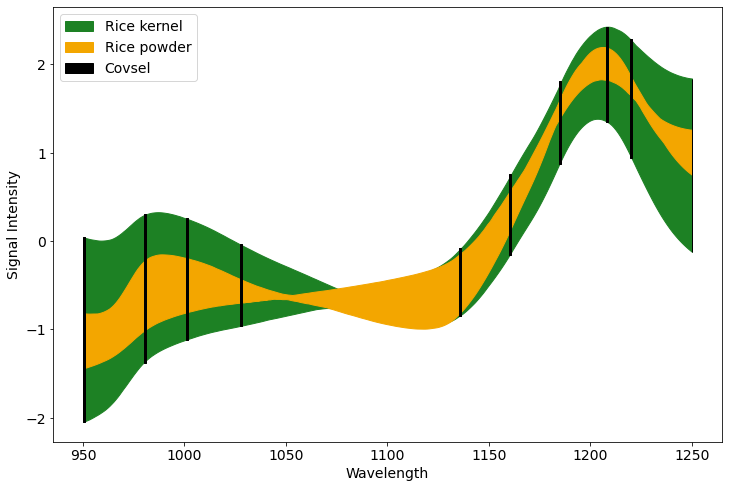

In [11]:

nvars = 10

plt.rcParams.update({'font.size': 14})
plt.subplots(figsize = (12, 8))
plt.fill_between(wv_range, np.amin(Xs,axis=0), np.amax(Xs,axis=0), color = "#1d8124",  label = source_name)
plt.fill_between(wv_range, np.amin(Xt,axis=0), np.amax(Xt,axis=0), color = "#f3a600",  label = target_name)
for wvi in selected_covsel[0:nvars]:
    plt.fill_between(wv_range[wvi:wvi+2],
                     np.amin(Xs[:,wvi:wvi+2]),
                     np.amax(Xs[:,wvi:wvi+2]), color = "black")
for wvi in selected_covsel[0:nvars]:
    plt.fill_between(wv_range[wvi:wvi+2],
                     np.amin(Xt[:,wvi:wvi+2]),
                     np.amax(Xt[:,wvi:wvi+2]), color = "black")
plt.fill_between(wv_range[wvi:wvi+2],np.amin(Xs[:,wvi:wvi+2]),np.amax(Xs[:,wvi:wvi+2]), color = "black", label = "Covsel")
plt.legend(loc = 2)
plt.xlabel("Wavelength")
plt.ylabel("Signal Intensity")
plt.show()


RMSECV:  0.40 BIASCV:  0.01 R2CV:  0.93 SEPCV:  0.40
RMSEP_s:  0.39 BIAS_s:  -0.03 R2P_s:  0.94 SEP_s:  0.39
RMSEP_t:  2.15 BIAS_s:  1.12 R2P_t:  0.21 SEP_t:  1.84
Nvar: 10 
RMSECV: 0.40 
$R^2CV$: 0.93


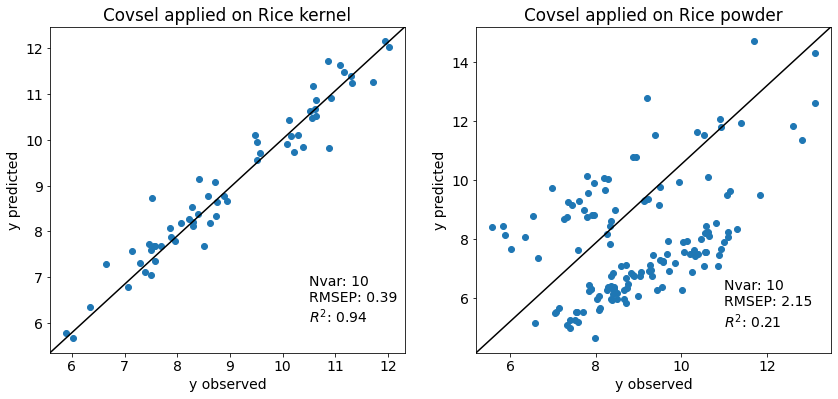

In [12]:
# MLR Covsel

mlr_covsel = LinearRegression()
mlr_covsel.fit(Xs[:, selected_covsel[0:nvars]],Ys)
Ys_test_pred = mlr_covsel.predict(Xs_test[:, selected_covsel[0:nvars]])
Yt_test_pred = mlr_covsel.predict(Xt_test[:, selected_covsel[0:nvars]])

# CV 

mlr_covsel_cv = cross_validate(mlr_covsel, Xs[:, selected_covsel[0:nvars]],Ys, cv=10, scoring = mlr_scoring)
rmsecv_s= np.sqrt(-1*mlr_covsel_cv["test_mse"].mean())
Ys_cv = cross_val_predict(mlr_covsel, Xs[:, selected_covsel[0:nvars]],Ys, cv=10)




rmsecv_s, bias_cv_s, r2cv_s, sepcv_s = performance_measures(Ys, Ys_cv)


# Evaluate MLR Covsel

rmsep_s, bias_p_s, r2p_s, sepp_s = performance_measures(Ys_test, Ys_test_pred)
rmsep_t, bias_p_t, r2p_t, sepp_t = performance_measures(Yt_test, Yt_test_pred)

print("RMSECV: ","{:.2f}".format(rmsecv_s), "BIASCV: ","{:.2f}".format(bias_cv_s), "R2CV: ", "{:.2f}".format(r2cv_s), "SEPCV: ","{:.2f}".format(sepcv_s))
print("RMSEP_s: ","{:.2f}".format(rmsep_s), "BIAS_s: ","{:.2f}".format(bias_p_s), "R2P_s: ", "{:.2f}".format(r2p_s), "SEP_s: ","{:.2f}".format(sepp_s))
print("RMSEP_t: ","{:.2f}".format(rmsep_t), "BIAS_s: ","{:.2f}".format(bias_p_t), "R2P_t: ", "{:.2f}".format(r2p_t), "SEP_t: ","{:.2f}".format(sepp_t))




cv_performance = "Nvar: {} \nRMSECV: {:.2f} \n$R^2CV$: {:.2f}".format(nvars,rmsecv_s, r2cv_s) 
print(cv_performance)



# # Evaluate MLR Covsel

# rmsep_s = np.sqrt(mean_squared_error(Ys_test, Ys_test_pred))
# # r2p_s = r2_score(Ys_test, Ys_test_pred)

# rmsep_t = np.sqrt(mean_squared_error(Yt_test, Yt_test_pred))
# # r2p_t = r2_score(Yt_test, Yt_test_pred)

# r2p_s = np.power(np.corrcoef(Ys_test.T, Ys_test_pred.T)[0,1],2)
# r2p_t = np.power(np.corrcoef(Yt_test.T, Yt_test_pred.T)[0,1],2)


# model performance


plt.figure(figsize = (14,6))


s_title = "Covsel applied on {}".format(source_name) 
s_performance = "Nvar: {} \nRMSEP: {:.2f} \n$R^2$: {:.2f}".format(nvars,rmsep_s, r2p_s) 


plt.subplot(1,2,1)
plt.scatter(Ys_test, Ys_test_pred)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k',transform=ax.transAxes)
plt.text(x = 10.5, y = 6, s=s_performance)
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(s_title) 


t_title = "Covsel applied on {}".format(target_name) 
t_performance = "Nvar: {} \nRMSEP: {:.2f} \n$R^2$: {:.2f}".format(nvars,rmsep_t, r2p_t) 

plt.subplot(1,2,2)
plt.scatter(Yt_test, Yt_test_pred)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k',transform=ax.transAxes)
plt.text(x = 11, y = 5, s=t_performance)
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(t_title) 
plt.show()



## Covsel overall performance

In [13]:
# MLR Covsel


rmsep_covsel = np.zeros(tvar)

for ni in range(1,tvar+1):


    mlr_covsel = LinearRegression()
    mlr_covsel.fit(Xs[:, selected_covsel[0:ni]],Ys)
    Ys_pred = mlr_covsel.predict(Xs[:, selected_covsel[0:ni]])
    Yt_test_pred = mlr_covsel.predict(Xt_test[:, selected_covsel[0:ni]])

    # Evaluate MLR Covsel

    rmsep_covsel[ni-1] = np.sqrt(mean_squared_error(Yt_test, Yt_test_pred))
    

    

# DICOVSEL

In [14]:
di_nvars_max = 30
minl = 3
maxl = 10
lambda_range = np.array([1e2,1e3,1e4,1e5,1e6,1e7,1e8])
selected_dicovsel = np.zeros((lambda_range.shape[0], di_nvars_max)).astype(np.int32)

for li, l_chosen in enumerate(lambda_range):
    
    dicovsel_output = dicovsel(X=Xs,Y=Ys,Xs=Xs, Xt=Xt,nvar=di_nvars_max, l = l_chosen, scaleY = False, weights = None)
    selected_dicovsel[li,:] = dicovsel_output[0]
    
    

## CV dicovsel

In [15]:



mlr_dicovsel = LinearRegression()
mlr_scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}

mlr_dicovsel_rmsecv = np.zeros((lambda_range.shape[0],tvar))
mlr_dicovsel_r2cv = np.zeros((lambda_range.shape[0],tvar))

for nvars_i in range(1,di_nvars_max+1):
    for li in range(lambda_range.shape[0]):
    
        mlr_dicovsel_cv = cross_validate(mlr_dicovsel, Xs[:, selected_dicovsel[li,0:nvars_i]],Ys, cv=10, scoring = mlr_scoring)
        mlr_dicovsel_rmsecv[li,nvars_i-1] = np.sqrt(-1*mlr_dicovsel_cv["test_mse"].mean())
        Ys_cv = cross_val_predict(mlr_dicovsel, Xs[:, selected_dicovsel[li,0:nvars_i]],Ys, cv=10)
        mlr_dicovsel_r2cv[li,nvars_i-1] = r2_score(Ys,Ys_cv)

    
    

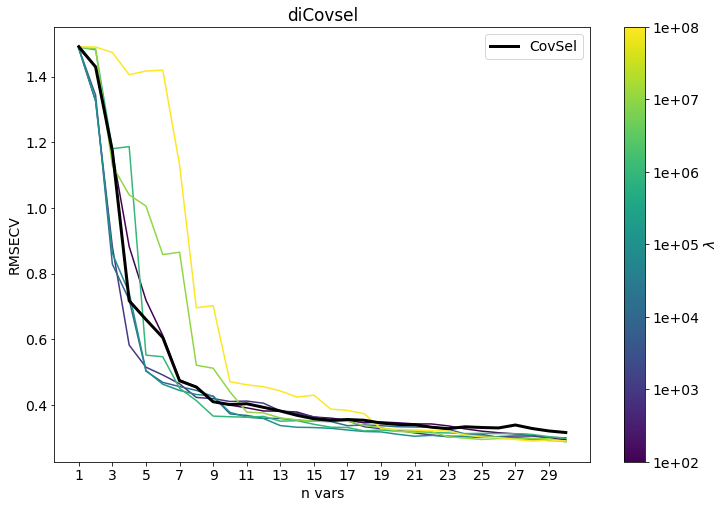

In [16]:
color_var = np.log(lambda_range).copy()
min_color_var = np.amin(color_var)
max_color_var = np.amax(color_var)

c_m = mtply.cm.viridis
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)




plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (12, 8))
for li in range(lambda_range.shape[0]):
    color_tuple = s_m.to_rgba(color_var[li])
    cax = ax.plot(np.arange(1, tvar+1), mlr_dicovsel_rmsecv[li,:], color = color_tuple)
# plt.colorbar(s_m, label = "$log(\lambda)$", ticks = [1,2,3])
cbar = fig.colorbar(s_m, label = "$\lambda$")
cbar.set_ticks(color_var[::1])
cbar.set_ticklabels(["{:.0e}".format(i) for i in lambda_range[::1]])
ax.plot(np.arange(1, tvar+1), mlr_covsel_rmsecv, c = "k", linewidth = 3, label= "CovSel")
ax.set_xticks(np.arange(1, tvar+1,2))
ax.set_title("diCovsel")
ax.set_xlabel("n vars")
ax.legend()
ax.set_ylabel("RMSECV")
plt.show()




### In terms of CV using the data in Xs and Ys, most values of lambda would render a good model for Xs, therefore, a medium value is chosen. The optimal number of variables remains around 10

## Selected dicovsel

In [17]:
di_nvars = 10
l_chosen = 1e6
covsel_output_steps = dicovsel(X=Xs,Y=Ys,Xs=Xs, Xt=Xt,nvar=tvar, l = 0,scaleY = False, weights = None)
dicovsel_output = dicovsel(X=Xs,Y=Ys,Xs=Xs, Xt=Xt,nvar=di_nvars_max, l = l_chosen,scaleY = False, weights = None)
selected_dicovsel = dicovsel_output[0]

    



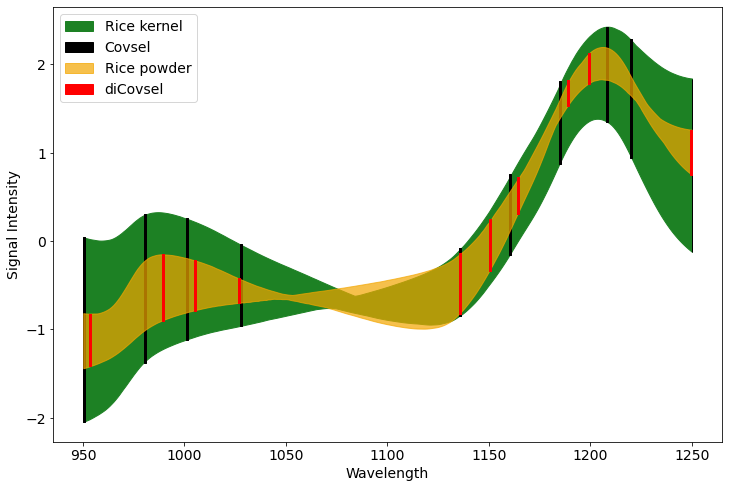

In [19]:

plt.rcParams.update({'font.size': 14})
plt.subplots(figsize = (12, 8))
# Covsel
plt.fill_between(wv_range, np.amin(Xs,axis=0), np.amax(Xs,axis=0), color = "#1d8124",  label = source_name)
for wvi in selected_covsel[0:nvars]:
    plt.fill_between(wv_range[wvi:wvi+2],
                     np.amin(Xs[:,wvi:wvi+2]),
                     np.amax(Xs[:,wvi:wvi+2]), color = "black")
plt.fill_between(wv_range[wvi:wvi+2],np.amin(Xs[:,wvi:wvi+2]),np.amax(Xs[:,wvi:wvi+2]), color = "black", label = "Covsel")
# diCovsel
plt.fill_between(wv_range, np.amin(Xt,axis=0), np.amax(Xt,axis=0), color = "#f3a600",  label = target_name, alpha = 0.7)
for wvi in selected_dicovsel[0:di_nvars]:
    plt.fill_between(wv_range[wvi:wvi+2],
                     np.amin(Xt[:,wvi:wvi+2]),
                     np.amax(Xt[:,wvi:wvi+2]), color = "red")
plt.fill_between(wv_range[wvi:wvi+2],np.amin(Xt[:,wvi:wvi+2]),np.amax(Xt[:,wvi:wvi+2]), color = "red", label = "diCovsel")
plt.legend(loc = 2)
plt.xlabel("Wavelength")
plt.ylabel("Signal Intensity")
plt.savefig("./figures/selected_variables.png")
plt.show()

## It can be seen from this graph how some selected wavlenthgs are kept from covsel, and how others are neighboring wavelengths 

## Steps in diCovsel

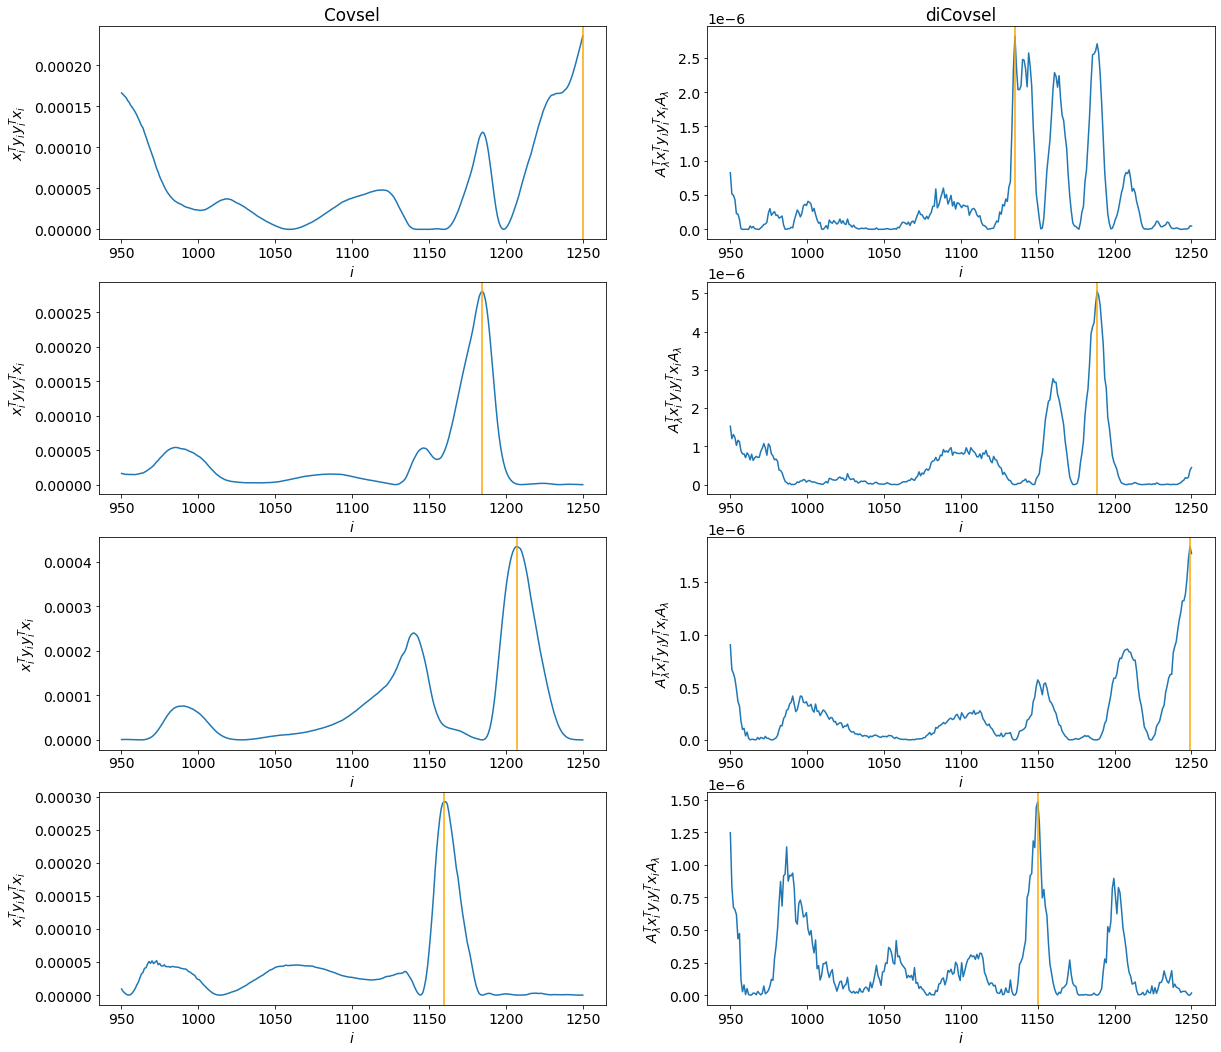

In [20]:
kmax = 4
first_covsel = covsel_output_steps[0][0:kmax]
first_dicovsel = dicovsel_output[0][0:kmax]
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(kmax,2,figsize = (20, 18))
for ki in range(kmax):
    axs[ki,0].plot(wv_range, covsel_output_steps[3][:,ki]**2)
    axs[ki,0].axvline(wv_range[first_covsel[ki]], 0, 1, color = "orange")
    axs[ki,0].set_xlabel("$i$")
    axs[ki,0].set_ylabel("$x_i^Ty_iy_i^Tx_i$")
    axs[ki,1].plot(wv_range, dicovsel_output[3][:,ki]**2)
    axs[ki,1].axvline(wv_range[first_dicovsel[ki]], 0, 1, color = "orange")
    axs[ki,1].set_xlabel("$i$")
    axs[ki,1].set_ylabel("$A_{\lambda}^Tx_i^Ty_iy_i^Tx_iA_{\lambda}$")

axs[0,0].set_title("Covsel")
axs[0,1].set_title("diCovsel")
plt.show()

RMSECV:  0.36 BIASCV:  0.00 R2CV:  0.94 SEPCV:  0.36
RMSEP_s:  0.35 BIAS_s:  0.00 R2P_s:  0.95 SEP_s:  0.35
RMSEP_t:  0.75 BIAS_s:  -0.09 R2P_t:  0.76 SEP_t:  0.74
Nvar: 10 
RMSECV: 0.36 
$R^2CV$: 0.94


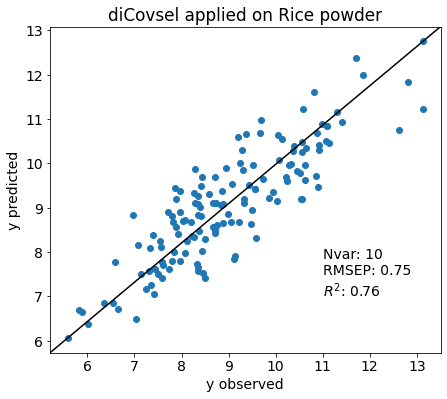

In [22]:
# MLR diCovsel

mlr_covsel = LinearRegression()
mlr_covsel.fit(Xs[:, selected_dicovsel[0:di_nvars]],Ys)
Ys_test_pred = mlr_covsel.predict(Xs_test[:, selected_dicovsel[0:di_nvars]])
Yt_test_pred = mlr_covsel.predict(Xt_test[:, selected_dicovsel[0:di_nvars]])


# CV 

mlr_dicovsel_cv = cross_validate(mlr_covsel, Xs[:, selected_dicovsel[0:di_nvars]],Ys, cv=10, scoring = mlr_scoring)
rmsecv_s= np.sqrt(-1*mlr_dicovsel_cv["test_mse"].mean())
Ys_cv = cross_val_predict(mlr_covsel, Xs[:, selected_dicovsel[0:di_nvars]],Ys, cv=10)



rmsecv_s, bias_cv_s, r2cv_s, sepcv_s = performance_measures(Ys, Ys_cv)


# Evaluate MLR Covsel

rmsep_s, bias_p_s, r2p_s, sepp_s = performance_measures(Ys_test, Ys_test_pred)
rmsep_t, bias_p_t, r2p_t, sepp_t = performance_measures(Yt_test, Yt_test_pred)

print("RMSECV: ","{:.2f}".format(rmsecv_s), "BIASCV: ","{:.2f}".format(bias_cv_s), "R2CV: ", "{:.2f}".format(r2cv_s), "SEPCV: ","{:.2f}".format(sepcv_s))
print("RMSEP_s: ","{:.2f}".format(rmsep_s), "BIAS_s: ","{:.2f}".format(bias_p_s), "R2P_s: ", "{:.2f}".format(r2p_s), "SEP_s: ","{:.2f}".format(sepp_s))
print("RMSEP_t: ","{:.2f}".format(rmsep_t), "BIAS_s: ","{:.2f}".format(bias_p_t), "R2P_t: ", "{:.2f}".format(r2p_t), "SEP_t: ","{:.2f}".format(sepp_t))




cv_performance = "Nvar: {} \nRMSECV: {:.2f} \n$R^2CV$: {:.2f}".format(di_nvars,rmsecv_s, r2cv_s) 
print(cv_performance)

# # Evaluate MLR diCovsel

# rmsep_s = np.sqrt(mean_squared_error(Ys_test, Ys_test_pred))
# # r2p_s = r2_score(Ys_test, Ys_test_pred)

# rmsep_t = np.sqrt(mean_squared_error(Yt_test, Yt_test_pred))
# # r2p_t = r2_score(Yt_test, Yt_test_pred)

# r2cv_s = np.power(np.corrcoef(Ys.T, Ys_cv.T)[0,1],2)
# r2p_s = np.power(np.corrcoef(Ys_test.T, Ys_test_pred.T)[0,1],2)
# r2p_t = np.power(np.corrcoef(Yt_test.T, Yt_test_pred.T)[0,1],2)



# model performance


plt.figure(figsize = (7,6))


t_title = "diCovsel applied on {}".format(target_name) 
t_performance = "Nvar: {} \nRMSEP: {:.2f} \n$R^2$: {:.2f}".format(di_nvars,rmsep_t, r2p_t) 


plt.scatter(Yt_test, Yt_test_pred)
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'k',transform=ax.transAxes)
plt.text(x = 11, y = 7, s=t_performance)
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(t_title) 
plt.show()



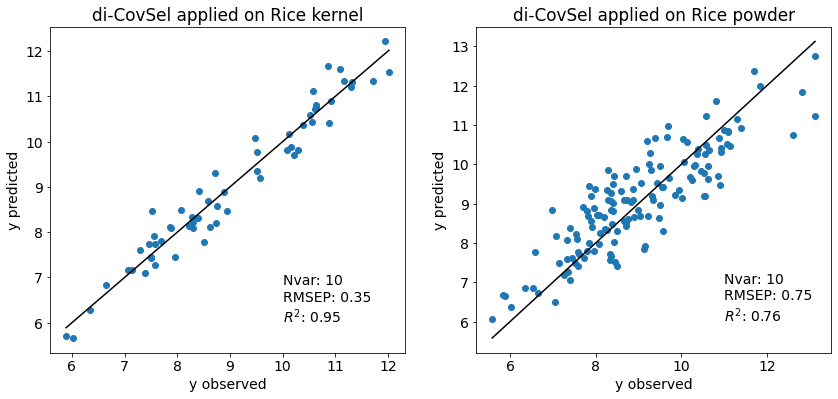

In [27]:
Ys_test_pred = mlr_covsel.predict(Xs_test[:, selected_dicovsel[0:di_nvars]])
Yt_test_pred = mlr_covsel.predict(Xt_test[:, selected_dicovsel[0:di_nvars]])

# Evaluate MLR Covsel

rmsep_s = np.sqrt(mean_squared_error(Ys_test, Ys_test_pred))
# r2p_s = r2_score(Ys_test, Ys_test_pred)

rmsep_t = np.sqrt(mean_squared_error(Yt_test, Yt_test_pred))
# r2p_t = r2_score(Yt_test, Yt_test_pred)

r2p_s = np.power(np.corrcoef(Ys_test.T, Ys_test_pred.T)[0,1],2)
r2p_t = np.power(np.corrcoef(Yt_test.T, Yt_test_pred.T)[0,1],2)


# model performance


plt.figure(figsize = (14,6))


s_title = "di-CovSel applied on {}".format(source_name) 
s_performance = "Nvar: {} \nRMSEP: {:.2f} \n$R^2$: {:.2f}".format(di_nvars,rmsep_s, r2p_s) 


plt.subplot(1,2,1)
plt.scatter(Ys_test, Ys_test_pred)
plt.plot([np.amin(Ys_test), np.amax(Ys_test)], [np.amin(Ys_test), np.amax(Ys_test)], 'k')
plt.text(x = 10, y = 6, s=s_performance)
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(s_title) 


t_title = "di-CovSel applied on {}".format(target_name) 
t_performance = "Nvar: {} \nRMSEP: {:.2f} \n$R^2$: {:.2f}".format(di_nvars,rmsep_t, r2p_t) 

plt.subplot(1,2,2)
plt.scatter(Yt_test, Yt_test_pred)
plt.plot([np.amin(Yt_test), np.amax(Yt_test)], [np.amin(Yt_test), np.amax(Yt_test)], 'k')
plt.text(x = 11, y = 6, s=t_performance)
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(t_title) 
plt.savefig("./figures/dicovsel_performance.png")
plt.show()

# DIPLS with dicovsel

In [26]:
lv_dipls_dicovsel = di_nvars

Xs_dicovsel = Xs[:, selected_dicovsel[0:di_nvars]]
Xt_dicovsel = Xt[:, selected_dicovsel[0:di_nvars]]
Xs_test_dicovsel = Xs_test[:, selected_dicovsel[0:di_nvars]]
Xt_test_dicovsel = Xt_test[:, selected_dicovsel[0:di_nvars]]


model_dipls = dipls(Xs_dicovsel-Xs_dicovsel.mean(axis=0),Ys-Ys.mean(axis=0),
                    Xs_dicovsel-Xs_dicovsel.mean(axis=0),
                    Xt_dicovsel-Xt_dicovsel.mean(axis=0),
                    A = lv_dipls_dicovsel, 
                    l = np.array(np.repeat(l_chosen,lv_dipls_dicovsel)).astype(np.float64))

B_dipls = model_dipls[0]
beta_dipls_s = Ys.mean(axis=0) - (Xs_dicovsel.mean(axis=0).dot(B_dipls))
beta_dipls_t = Ys.mean(axis=0) - (Xt_dicovsel.mean(axis=0).dot(B_dipls))



# crossval performance

ycal_cv = cross_val_predict_dipls(Xs_dicovsel, Ys,Xt_dicovsel, lv_dipls_dicovsel,l_chosen, n_splits_cv = 10)

# source and target

Ys_test_pred = Xs_test_dicovsel.dot(B_dipls) + beta_dipls_s

Yt_test_pred = Xt_test_dicovsel.dot(B_dipls) + beta_dipls_t


# Evaluate PLS


rmsecv_s, bias_cv_s, r2cv_s, sepcv_s = performance_measures(ycal_pls, ycal_cv)
rmsep_s, bias_p_s, r2p_s, sepp_s = performance_measures(Ys_test, Ys_test_pred)
rmsep_t, bias_p_t, r2p_t, sepp_t = performance_measures(Yt_test, Yt_test_pred)



model_performance = {}
model_performance["Property"] = "Rice"
model_performance["Model"] = "diPLS di-CovSel variables"
model_performance["LV"] = lv_dipls_dicovsel
model_performance["lambda"] = "{:.0e}".format(l_chosen)
model_performance["RMSECV"] = "{:.2f}".format(rmsecv_s)
model_performance["R2CV"] = "{:.2f}".format(r2cv_s)
model_performance["BiasCV"] = "{:.2f}".format(bias_cv_s)
model_performance["SEPCV"] = "{:.2f}".format(sepcv_s)

model_performance["RMSEP (source)"] = "{:.2f}".format(rmsep_s)
model_performance["R2P (source)"] = "{:.2f}".format(r2p_s)
model_performance["BiasP_s"] = "{:.2f}".format(bias_p_s)
model_performance["SEPP_s"] = "{:.2f}".format(sepp_s)


model_performance["RMSEP (target)"] = "{:.2f}".format(rmsep_t)
model_performance["R2P (target)"] = "{:.2f}".format(r2p_t)
model_performance["BiasP_t"] = "{:.2f}".format(bias_p_t)
model_performance["SEPP_t"] = "{:.2f}".format(sepp_t)


pd.DataFrame([model_performance])

,Property,Model,LV,lambda,RMSECV,R2CV,BiasCV,SEPCV,RMSEP (source),R2P (source),BiasP_s,SEPP_s,RMSEP (target),R2P (target),BiasP_t,SEPP_t
0,Rice,diPLS di-CovSel variables,10,1e+06,0.36,0.94,0.00,0.36,0.35,0.95,0.00,0.35,0.75,0.76,0.09,0.74


## dicovsel performance

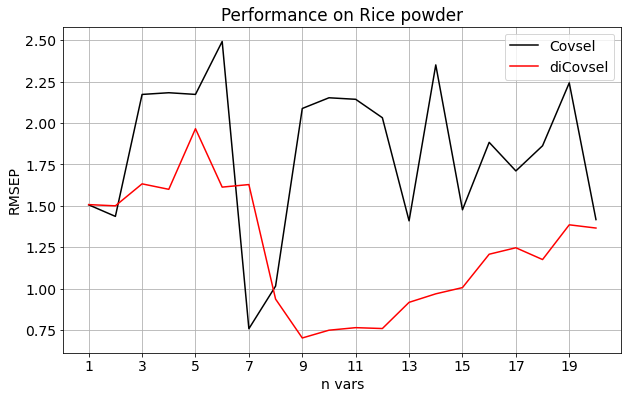

In [28]:
# MLR DICovsel
di_nvars_max = 20

rmsep_dicovsel = np.zeros(di_nvars_max)

for ni in range(1,di_nvars_max+1):


    mlr_dicovsel = LinearRegression()
    mlr_dicovsel.fit(Xs[:, selected_dicovsel[0:ni]],Ys)
    Yt_test_pred = mlr_dicovsel.predict(Xt_test[:, selected_dicovsel[0:ni]])

    # Evaluate MLR diCovsel

    rmsep_dicovsel[ni-1] = np.sqrt(mean_squared_error(Yt_test, Yt_test_pred))
    


plt.subplots(figsize = (10,6))
plt.plot(np.arange(1, di_nvars_max+1), rmsep_covsel[:di_nvars_max], label = "Covsel", color = "black")
plt.plot(np.arange(1, di_nvars_max+1), rmsep_dicovsel, label = "diCovsel", color = "red")
plt.xlabel("n vars")
plt.ylabel("RMSEP")
plt.legend(loc = 1)
plt.grid()
plt.xticks(np.arange(1, di_nvars_max+1,2))
plt.title("Performance on {}".format(target_name))
plt.show()